# Data analysis and preprocess
The aim of this notebook is to find the relationship between price and some features we care about and preprocess the data, making it can be used in our price predict model.
It contains two parts:
1. Search the relationship between price and some features we care about
    * Will price be different in different location of listing in Seattle?
    * Will the number of amenities influence price? If so, which amenities influence price the most?<br><br>

2. Preprocess the data<br><br>

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('Seattle_Airbnb_Open_Data\cleaned_listings.csv')
print('The shape of data:', data.shape)
data.head()

The shape of data: (3818, 74)


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,zipcode,is_location_exact,...,heating,washer,dryer,elevator,pets_allowed,dog,cat,hot_tub,amenity_count,guests_count
0,2,0.96,1.00,0,Queen Anne,3.00,1,1,19,1,...,1,1,1,0,0,0,0,0,8,218.00
1,1,0.98,1.00,1,Queen Anne,6.00,1,1,19,1,...,1,1,1,0,0,0,0,0,15,45.00
2,2,0.67,1.00,0,Queen Anne,2.00,1,1,19,1,...,1,1,1,0,1,1,1,1,19,21.00
3,96,0.00,0.00,0,Queen Anne,1.00,1,1,19,1,...,1,1,1,0,0,0,0,0,13,0.00
4,1,1.00,0.00,0,Queen Anne,2.00,1,1,19,1,...,1,0,0,0,0,0,0,0,11,41.00


Look at the distribution of **price**

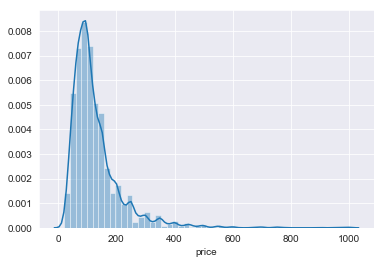

In [4]:
sns.distplot(data['price']);

The distribution of **price** is obviously a right-skewed distribution

## Part 1: Search the relationship between price and some features we care about

### Question 1: Will price be different in different location of listing in Seattle?

* Search the relationship between price and zipcode

    Different zipcodes represent different region in Seattle, so that we can use zipcode to find if the price is different in these regions.

In [5]:
zipcodes = list(data['zipcode'].unique())
zipcodes.remove(0)
zipcodes.sort()
zipcodes

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 12,
 15,
 16,
 17,
 18,
 19,
 21,
 22,
 25,
 26,
 33,
 34,
 36,
 44,
 46,
 77,
 78,
 99]

In previous notebook we have transformed **zipcode** into numeric data, now in order to observe the relationship between price and zipcode directly, we need to transform it back. 

In [6]:
for i in range(len(zipcodes)):
    zipcode = zipcodes[i]
    if len(str(zipcode)) < 2:
        zipcodes[i] = '9810' + str(zipcode)
    else:
        zipcodes[i] = '981' + str(zipcode)
zipcodes

['98101',
 '98102',
 '98103',
 '98104',
 '98105',
 '98106',
 '98107',
 '98108',
 '98109',
 '98112',
 '98115',
 '98116',
 '98117',
 '98118',
 '98119',
 '98121',
 '98122',
 '98125',
 '98126',
 '98133',
 '98134',
 '98136',
 '98144',
 '98146',
 '98177',
 '98178',
 '98199']

In [7]:
def zipcode_trans(ind):
    if len(str(ind)) < 2:
        out = '9810' + str(ind)
    else:
        out = '981' + str(ind)
    return out

In [8]:
zipcode_price = pd.DataFrame(data[data['zipcode'] != 0].groupby('zipcode')['price'].mean())
zipcode_price['zipcode_str'] = '0'
for ind in zipcode_price.index:
    zipcode_price.loc[ind, 'zipcode_str'] = zipcode_trans(ind)
zipcode_price.head()

,price,zipcode_str
zipcode,,
1,166.72,98101
2,127.10,98102
3,124.15,98103
4,135.22,98104
5,107.11,98105


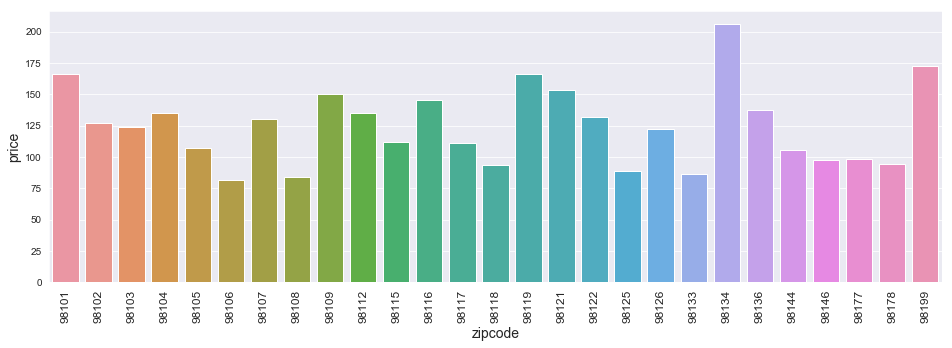

In [8]:
plt.figure(figsize=(16, 5))
g = sns.barplot(zipcode_price['zipcode_str'], zipcode_price['price'])
g.set_xticklabels(zipcodes, fontsize=12, rotation=90)
g.set_xlabel('zipcode', fontsize=14)
g.set_ylabel('price', fontsize=14)
plt.show()

#### Conclusion 1:
Average price in different region is different, and the average price is highest in the region whose zipcode is 98134 while the accomodations in regions whose zipcode are 98106, 98108 are very cheap.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text xticklabel objects>)

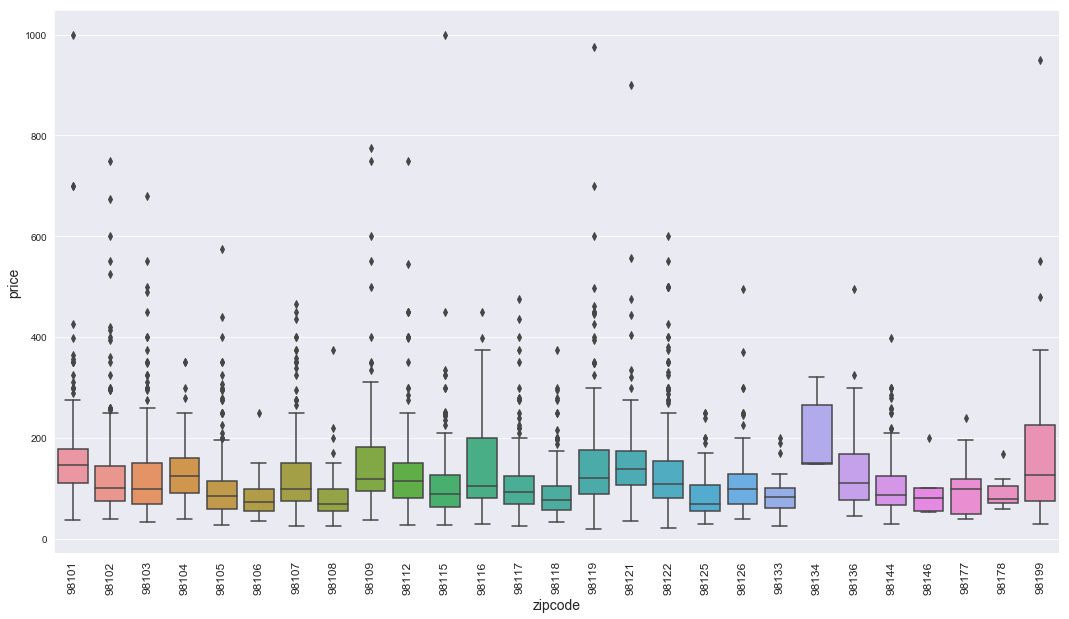

In [9]:
plt.figure(figsize=(18, 10))
g = sns.boxplot(x='zipcode', y='price', data=data[data['zipcode']!=0])
plt.xlabel('zipcode', fontsize=14)
plt.ylabel('price', fontsize=14)
g.set_xticklabels(zipcodes, fontsize=12, rotation=90)
plt.xticks(rotation=90, fontsize=12)

#### Conclusion 2:
In almost every regions there are some listings obviously more expensive than others, and in the region wose zipcode is 98199 the price span is very large, which means in that region you can find cheap accomodations but also very expensive one. 

* Search the relationship between **price** and **host_neighbourhood**

    Although in the same region, the price might be different. According to our life experience, hotels which near the center of city or tourist spots are usually expencive. So host_neighbourhood might be an important feature related to price.

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102]),
 <a list of 103 Text xticklabel objects>)

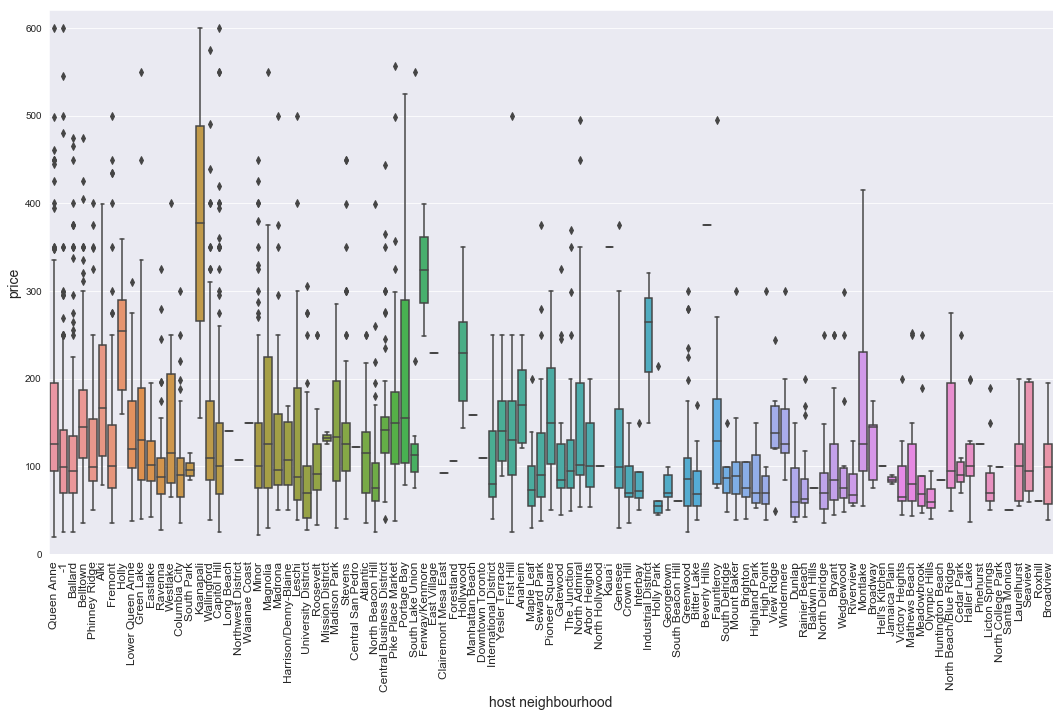

In [9]:
plt.figure(figsize=(18, 10))
sns.boxplot(x='host_neighbourhood', y='price', data=data);
plt.xlabel('host neighbourhood', fontsize=14)
plt.ylabel('price', fontsize=14)
plt.ylim(0, 620)
plt.xticks(rotation=90, fontsize=12)

#### Conclusion 3:
The price of listings near Kaanapali is highest, while listings near Holly park are really cheap. 

### Question 2: Will the number of amenities influence price? If so, which amenities influence price the most?

In [10]:
amenity_cnts = list(data['amenity_count'].unique())
amenity_cnts.sort()
amenity_cnts

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29]

In [11]:
amenity_price = pd.DataFrame(amenity_cnts)
amenity_price['price'] = data.groupby('amenity_count')['price'].mean().values
amenity_price.columns = ['amenity_count', 'price']
amenity_price.head()

,amenity_count,price
0,1,126.34
1,2,85.50
2,3,85.43
3,4,104.39
4,5,104.92


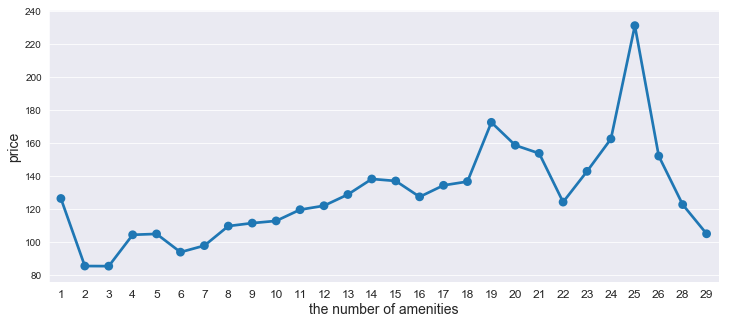

In [12]:
plt.figure(figsize=(12, 5))
g = sns.pointplot(x='amenity_count', y='price', data=amenity_price)
g.set_xticklabels(amenity_cnts, fontsize=12)
g.set_xlabel('the number of amenities', fontsize=14)
g.set_ylabel('price', fontsize=14)
plt.show()

#### Conclusion 4:
The number of amenities will influence the price of listings. In general, when the number of amenities is between 6 and 14, the more amenities the listings have, the higher the price is. when the number of amenities is more than 14, the regular pattern of price changing is not that obvious. Another interesting thing is that when the number of amenities is 25, the price is abnormally higher than others.

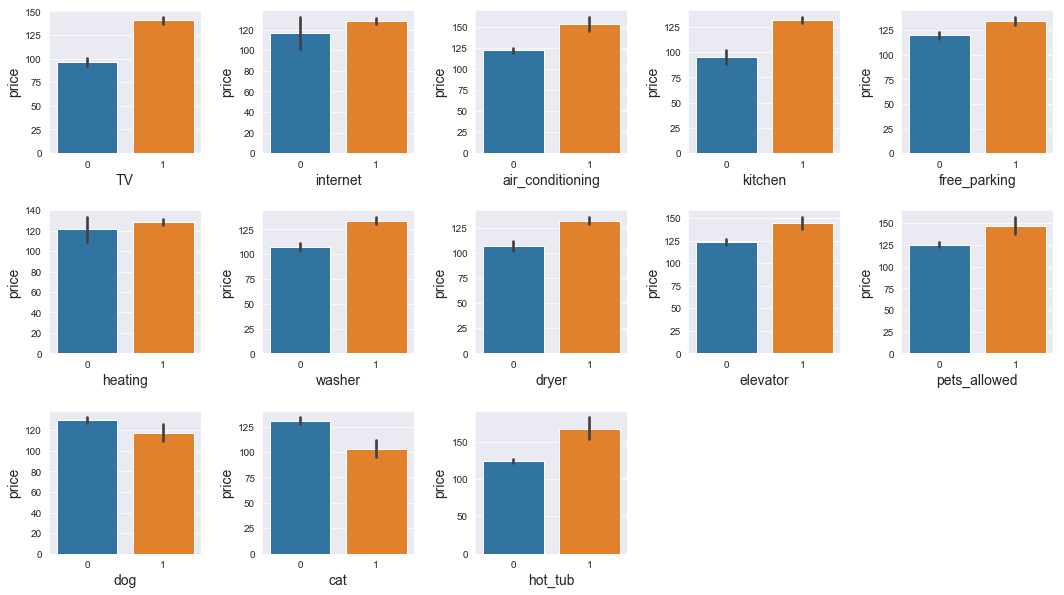

In [13]:
all_amenity = ['TV', 'internet', 'air_conditioning', 'kitchen', 'free_parking', 'heating', 'washer', 'dryer', 'elevator', 'pets_allowed', 'dog', 'cat', 'hot_tub']
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, amenity in enumerate(all_amenity):
    plt.subplot(3, 5, i+1)
    g = sns.barplot(x=amenity, y='price', data=data)
    g.set_xlabel(amenity, fontsize=14)
    g.set_ylabel('price', fontsize=14)
plt.show()

#### Conclusion 5:
The price is really different between listings with TV and those without TV, while heating almost does not infulence the price. It is interesting that listings without dogs or cats are more expensive than thouse with dogs of cats.

## Part 2: Preprocess data

* Correlation analysis among multiple variables

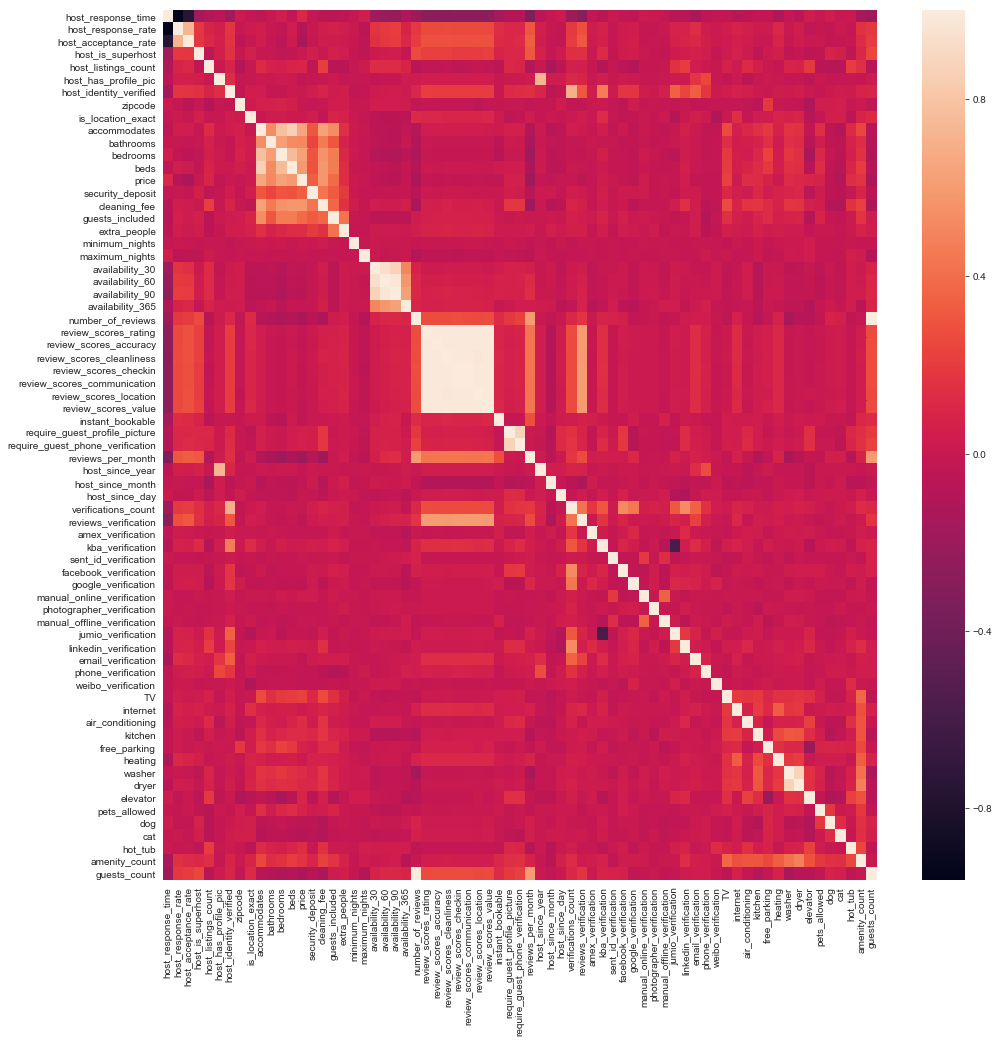

In [15]:
corrs = data.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corrs)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

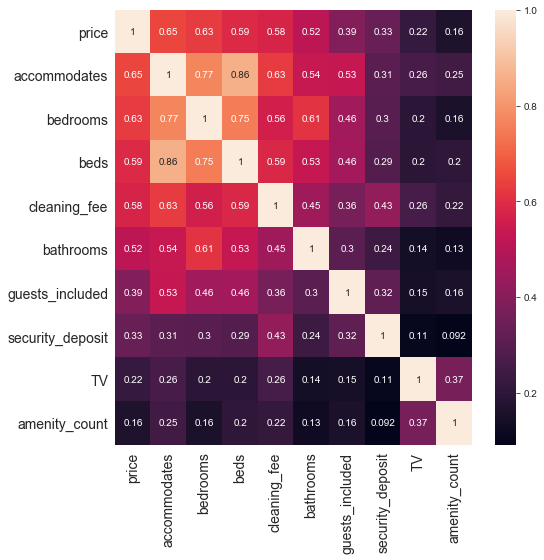

In [16]:
#Check the ten variables with the highest correlation with the target value
cols_10 = corrs.nlargest(10, 'price')['price'].index
corrs_10 = data[cols_10].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corrs_10, annot=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

* Relationship analysis among multiple variables

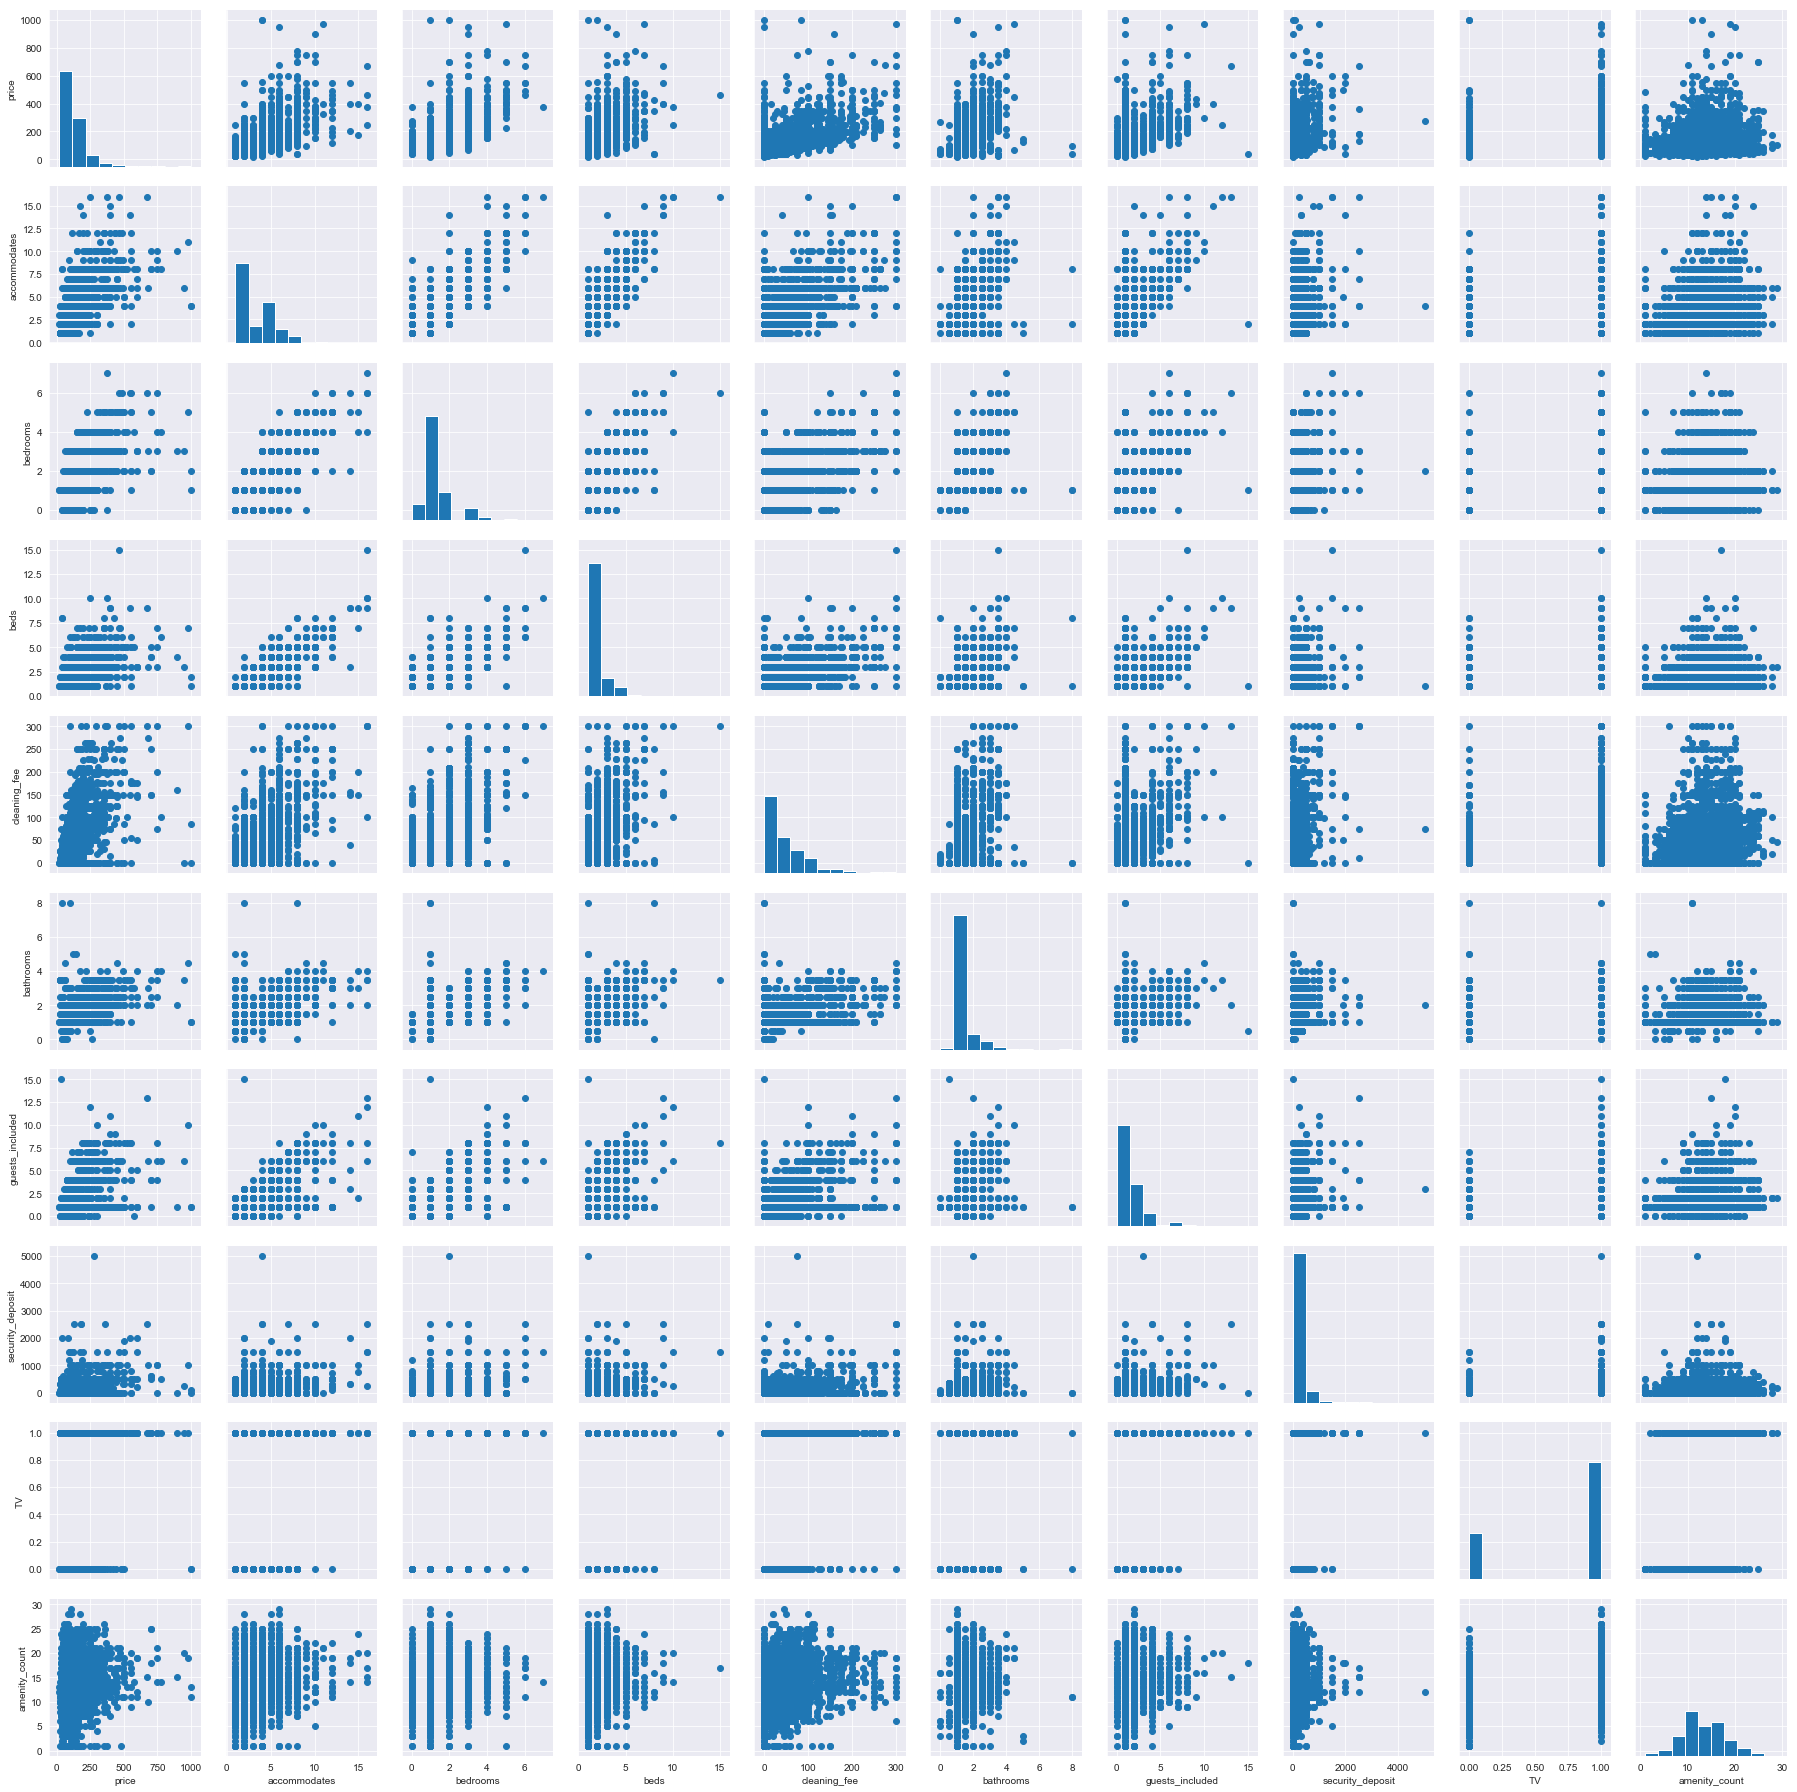

In [17]:
g = sns.PairGrid(data[cols_10])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

* Transform price distribution into normal distribution

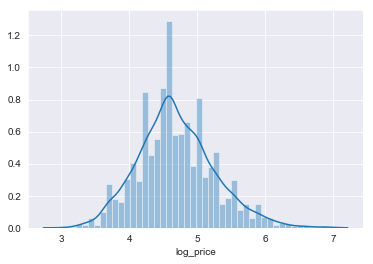

In [18]:
data['log_price'] = np.log1p(data['price'])
sns.distplot(data['log_price'])

* drop outliers

In [19]:
price_avg = data['log_price'].mean()
price_std = data['log_price'].std()
price_low = price_avg - 3*price_std
price_high = price_avg + 3*price_std

data = data.drop(data[(data['log_price']<price_low) | (data['log_price']>price_high)].index)
print(data.shape)

(3800, 75)


In [20]:
y = data['log_price']
data = data.drop(['price', 'log_price'], axis=1)
print(data.shape)
print(y.shape)

(3800, 73)
(3800,)


* Encode categorical features with dummy

In [21]:
cat_features = list(data.select_dtypes(include=['object']).columns.values)
cat_features

['host_neighbourhood',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [22]:
for col in cat_features:
    data = pd.concat([data.drop(col, axis=1), pd.get_dummies(data[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
print(data.shape)
data.head()

(3800, 193)


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,zipcode,is_location_exact,accommodates,...,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,2,0.96,1.00,0,3.00,1,1,19,1,4,...,0,0,0,0,0,0,0,1,1,0
1,1,0.98,1.00,1,6.00,1,1,19,1,4,...,0,0,0,0,0,0,0,1,0,1
3,96,0.00,0.00,0,1.00,1,1,19,1,3,...,0,0,0,0,0,0,0,1,0,0
4,1,1.00,0.00,0,2.00,1,1,19,1,6,...,0,0,0,0,0,0,0,1,0,1
5,96,0.00,0.00,0,1.00,1,1,19,1,2,...,0,0,1,0,0,0,0,1,0,1


* Handle features whose skewness are more than 0.5 using boxcox

In [23]:
num_features = list(data.select_dtypes(include=['float', 'int']).columns.values)
num_features

['host_response_rate',
 'host_acceptance_rate',
 'host_listings_count',
 'bathrooms',
 'bedrooms',
 'beds',
 'security_deposit',
 'cleaning_fee',
 'extra_people',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'guests_count']

In [24]:
skewness = data[num_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = skewness[skewness>0.5]
skew_features = skewness.index
skewness

host_listings_count   9.46
security_deposit      5.55
extra_people          5.24
guests_count          4.07
bathrooms             2.96
beds                  2.48
cleaning_fee          1.72
bedrooms              1.50
reviews_per_month     1.48
dtype: float64

In [25]:
for col in skew_features:
    lam = stats.boxcox_normmax(data[col]+1)   
    data[col] = boxcox1p(data[col], lam)

In [26]:
data.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,zipcode,is_location_exact,accommodates,...,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,2,0.96,1.00,0,0.70,1,1,19,1,4,...,0,0,0,0,0,0,0,1,1,0
1,1,0.98,1.00,1,0.78,1,1,19,1,4,...,0,0,0,0,0,0,0,1,0,1
3,96,0.00,0.00,0,0.48,1,1,19,1,3,...,0,0,0,0,0,0,0,1,0,0
4,1,1.00,0.00,0,0.63,1,1,19,1,6,...,0,0,0,0,0,0,0,1,0,1
5,96,0.00,0.00,0,0.48,1,1,19,1,2,...,0,0,1,0,0,0,0,1,0,1


In [27]:
data['log_price'] = y
print(data.shape)
data.head()

(3800, 194)


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,zipcode,is_location_exact,accommodates,...,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,log_price
0,2,0.96,1.00,0,0.70,1,1,19,1,4,...,0,0,0,0,0,0,1,1,0,4.45
1,1,0.98,1.00,1,0.78,1,1,19,1,4,...,0,0,0,0,0,0,1,0,1,5.02
3,96,0.00,0.00,0,0.48,1,1,19,1,3,...,0,0,0,0,0,0,1,0,0,4.62
4,1,1.00,0.00,0,0.63,1,1,19,1,6,...,0,0,0,0,0,0,1,0,1,6.11
5,96,0.00,0.00,0,0.48,1,1,19,1,2,...,0,1,0,0,0,0,1,0,1,4.80


* Save the data

In [29]:
data.to_csv('Seattle_Airbnb_Open_Data\listings_data.csv', index=False)